In [1]:
import os
from datasets import load_dataset
from segment.create_dataset import CreateSegmentationDataset
from segment.utils import load_resize_image
import random
from datasets import Dataset
from huggingface_hub import create_repo

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [2]:
# import yaml
# # loading yaml config file
# @lru_cache(maxsize=None)
# def load_yaml(path):
#     with open(path, "r") as file:
#         data = yaml.load(file, Loader=yaml.FullLoader)
#     return data

# # Get the labels dictionary from the config file
# @lru_cache(maxsize=None)
# def get_labels_dict(config_path):
#     data = load_yaml(config_path)
#     labels_dict = data.get("names")
#     labels_dict = {v: k for k, v in labels_dict.items()}
#     return labels_dict

# class SegmentTrain:
#     def __init__(self):
#         pass

#     def create_yolo_config(self, save_path: str):
#         """Create and save the YOLO config YAML file."""
#         config = {"names": {i: label for label, i in self.labels_dict.items()}}
#         with open(save_path, "w") as file:
#             yaml.dump(config, file)
    # def _get_labels_dict(self) -> Dict[str, int]:
    #     """Get labels dictionary from the text prompt."""
    #     labels = self.text_prompt.split(".")
    #     return {label: i for i, label in enumerate(labels)}


In [3]:
# from datasets import Dataset
# from typing import Union, List
# from segment.visualizer import visualizer

# def filter_rows_of_dataset(dataset: Dataset, filter_function):
#     """
#     Apply a filter function to the rows of a dataset.

#     :param dataset: The input dataset
#     :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
#     :return: A new dataset with filtered rows
#     """

#     return dataset.filter(filter_function)

# def filter_list_in_column(dataset: Dataset, column_name: str, filter_function):
#     """
#     Apply a filter function to a column containing lists of dictionaries.

#     :param dataset: The input dataset
#     :param column_name: The name of the column containing lists to filter
#     :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
#     :return: A new dataset with filtered lists in the specified column
#     """

#     def transform_fn(example):
#         filtered_list = [item for item in example[column_name] if filter_function(item)]
#         return {column_name: filtered_list}

#     return dataset.map(transform_fn)


# def score_filter(item, score_cutoff=0.5):
#     return item.get("score", 0) > score_cutoff

# class Segment(CreateSegmentationDataset):
#     def __init__(self, ds: Dataset, text_prompt: Union[List, str], image_col='image',md_col='metadata', **kwargs):
#         super().__init__(ds, text_prompt, **kwargs)
#         self.ds = ds
#         self.text_prompt = text_prompt
#         self.image_col = image_col
#         self.md_col = md_col
        
    
#     def display(self, row_num=None):
#         if row_num is None:
#             row_num = random.randint(0, len(self.ds) - 1)

#         row = self.ds[row_num]
#         image = row[self.image_col]
#         metadata = row[self.md_col]
        
#         if not bool(metadata):
#             raise ValueError("No metadata found for this image")
        
#         visualizer(image, metadata)
    
#     def filter_scores(self, score_cutoff: float):
#         """
#         Filter the processed dataset based on segmentation scores.

#         Args:
#             score_cutoff (float): The minimum score to keep a segmentation result.

#         Raises:
#             AssertionError: If there is no processed dataset to filter.
#         """
#         assert self.ds is not None, "There is no processed dataset to filter"

#         self.ds = filter_list_in_column(
#             self.ds,
#             self.metadata_col,
#             lambda x: x.get("score", 0) > score_cutoff,
#         )
    
#     # remove any items from the md lists that are empty
#     def remove_empty_rows(self, empty_col='metadata'):
#         def remove_none(item):
#             return bool(item[empty_col])

#         self.ds = filter_rows_of_dataset(self.ds, remove_none)
    
        
#     def push_to_hub(self, repo_id, token, commit_message="md", private=True):
#         create_repo(
#             repo_id=repo_id,
#             repo_type="dataset",
#             exist_ok=True,
#             private=private,
#             token=token,
#         )

#         self.ds.push_to_hub(
#             repo_id, commit_message=commit_message, token=token
#         )

#         print(f"Pushed Dataset to Hub: {repo_id}")
        
    

In [4]:
import logging
from typing import Union, List, Optional, Dict, Any, Callable
from datasets import Dataset, concatenate_datasets
import numpy as np
from tqdm.auto import tqdm
import math
from PIL import Image
from segment.components.detect.DetectDino import DetectDino
from segment.components.segment.SegmentSam import SegmentSam
from segment.format_results import format_all_results
from segment.utils import *
from segment.utils import get_device

class CreateSegmentationDataset:
    """
    A robust class for creating and managing segmentation datasets based on text prompts.

    This class processes a given dataset to extract segmentation masks, bounding boxes,
    and other metadata based on text prompts. It supports efficient batch processing,
    provides methods for filtering results, and includes error handling and logging.

    Attributes:
        ds (Dataset): The input dataset to be processed.
        text_prompt (Union[str, List[str]]): Text prompt(s) for segmentation.
        metadata_col (str): The name of the column where metadata will be stored.
        batch_size (int): Batch size for processing.
        sub_batch_size (int): Sub-batch size for processing within each batch.
        box_threshold (float): Threshold for box detection.
        text_threshold (float): Threshold for text detection.
        iou_threshold (float): Threshold for IOU.
        image_size (int): Size to resize images to before processing.
        logger (logging.Logger): Logger for the class.

    Args:
        ds (Dataset): The input dataset to be processed.
        text_prompt (Union[str, List[str]]): Text prompt(s) for segmentation.
        metadata_col (str, optional): Name of the column to store metadata. Defaults to 'metadata'.
        batch_size (int, optional): Batch size for processing. Defaults to 64.
        sub_batch_size (int, optional): Sub-batch size for processing. Defaults to 8.
        box_threshold (float, optional): Threshold for box detection. Defaults to 0.3.
        text_threshold (float, optional): Threshold for text detection. Defaults to 0.25.
        iou_threshold (float, optional): Threshold for IOU. Defaults to 0.8.
        image_size (int, optional): Size to resize images to before processing. Defaults to 1024.
    """

    def __init__(
        self,
        ds: Dataset,
        text_prompt: Union[str, List[str]],
        metadata_col: str = "metadata",
        batch_size: int = 64,
        sub_batch_size: int = 8,
        box_threshold: float = 0.3,
        text_threshold: float = 0.25,
        iou_threshold: float = 0.8,
        image_size: int = 1024,
    ):
        self.ds = ds
        self.metadata_col = metadata_col
        self.text_prompt = self._process_text_prompt(text_prompt)
        self.batch_size = batch_size
        self.sub_batch_size = sub_batch_size
        self.box_threshold = box_threshold
        self.text_threshold = text_threshold
        self.iou_threshold = iou_threshold
        self.image_size = image_size
        self.logger = self._setup_logger()
        
        # Initialize SegmentSam and DetectDino
        self.sam = SegmentSam()
        self.dino = DetectDino()

    def _setup_logger(self) -> logging.Logger:
        """Set up and return a logger for the class."""
        logger = logging.getLogger(__name__)
        logger.setLevel(logging.INFO)
        handler = logging.StreamHandler()
        formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        handler.setFormatter(formatter)
        logger.addHandler(handler)
        return logger

    def _process_text_prompt(self, text_prompt: Union[str, List[str]]) -> str:
        """Process the text prompt."""
        if isinstance(text_prompt, str):
            return text_prompt
        elif isinstance(text_prompt, list):
            return ".".join(text_prompt)
        else:
            raise ValueError("text_prompt must be a string or a list of strings")

    def _remove_masks(self, batch_results):
        """Remove mask data from batch results to reduce memory usage."""
        for b in batch_results:
            for row in b:
                row.pop("mask", None)
        return batch_results

    def _load_resize_image(self, image_path: Union[str, Image.Image], size: int) -> Image.Image:
        """Load and resize an image."""
        if isinstance(image_path, str):
            image = Image.open(image_path).convert("RGB")
        elif isinstance(image_path, Image.Image):
            image = image_path.convert("RGB")
        else:
            raise ValueError("image_path must be a string or a PIL Image")
        
        aspect_ratio = image.width / image.height
        if aspect_ratio > 1:
            new_width = size
            new_height = int(size / aspect_ratio)
        else:
            new_height = size
            new_width = int(size * aspect_ratio)
        return image.resize((new_width, new_height), Image.LANCZOS)

    def get_metadata(self, image_paths: List[str | Image.Image]) -> List[Dict]:
        """Get metadata for a batch of images."""
        images = [self._load_resize_image(im, self.image_size) for im in image_paths]

        # Get the boxes from the prompts using DINO
        self.dino.process(images, self.text_prompt, box_threshold=self.box_threshold, text_threshold=self.text_threshold)

        # Get the masks from the images and boxes using SAM
        boxes = self.dino.boxes
        phrases = self.dino.phrases
        
        sam_results = self.sam.process(images, boxes, phrases)
        
        self.dino.reset()

        return format_all_results(sam_results)  # Assuming format_all_results is imported or defined elsewhere

    def process_batch(self, batch: Dict[str, Any]) -> Dict[str, List[Dict[str, Any]]]:
        """Process a batch of images and retrieve metadata."""
        image_paths = batch["image"]
        results = []

        with tqdm(
            total=len(image_paths),
            desc="Processing Images",
            unit="img",
            leave=False,
            position=1,
        ) as pbar:
            for i in range(0, len(image_paths), self.sub_batch_size):
                sub_batch = image_paths[i : i + self.sub_batch_size]
                pbar.set_description(f"Sub Batch: {i // self.sub_batch_size + 1}")

                batch_results = self.get_metadata(sub_batch)

                if batch_results:
                    self._remove_masks(batch_results)
                    results.extend(batch_results)

                pbar.update(len(sub_batch))

        return {self.metadata_col: results}

    def process(self):
        """
        Process the dataset to extract segmentation metadata.

        This method applies the segmentation model to the dataset in batches,
        adding the resulting metadata to a new column in the dataset.
        """
        self.logger.info("Starting dataset processing")
        try:
            num_batches = math.ceil(len(self.ds) / self.batch_size)
            batches = []

            with tqdm(
                total=num_batches,
                desc="Processing Batches",
                unit="batch",
                position=0,
                leave=False,
            ) as pbar:
                for i in range(num_batches):
                    pbar.set_description(f"Processing Batch: {i}")
                    start_idx = i * self.batch_size
                    end_idx = min((i + 1) * self.batch_size, len(self.ds))

                    # Process this batch
                    batch_results = self.ds.select(range(start_idx, end_idx)).map(
                        self.process_batch,
                        batched=True,
                        batch_size=self.batch_size,
                    )

                    batches.append(batch_results)

                    pbar.update(1)

            # Update the dataset with the new results
            self.ds = concatenate_datasets(batches)
            self.logger.info("Dataset processing completed successfully")
        except Exception as e:
            self.logger.error(f"Error during dataset processing: {str(e)}")
            raise

    def filter_results(self, min_score: float = 0.0, min_area: float = 0.0):
        """
        Filter the processed results based on score and area.

        Args:
            min_score (float, optional): Minimum score to keep a result. Defaults to 0.0.
            min_area (float, optional): Minimum area (as a fraction of image area) to keep a result. Defaults to 0.0.
        """
        def filter_metadata(example):
            filtered = [
                item for item in example[self.metadata_col]
                if item['score'] >= min_score and item['area'] >= min_area
            ]
            example[self.metadata_col] = filtered
            return example

        self.logger.info(f"Filtering results with min_score={min_score} and min_area={min_area}")
        self.ds = self.ds.map(filter_metadata)

    def get_dataset(self) -> Dataset:
        """Return the processed dataset."""
        return self.ds

    def perform_sanity_check(self, num_samples: int = 5):
        """
        Perform a sanity check on a subset of the processed dataset.

        Args:
            num_samples (int, optional): Number of samples to check. Defaults to 5.
        """
        self.logger.info(f"Performing sanity check on {num_samples} samples")
        samples = self.ds.select(range(min(num_samples, len(self.ds))))
        
        for i, sample in enumerate(samples):
            self.logger.info(f"Sample {i + 1}:")
            self.logger.info(f"  Image path: {sample['image']}")
            self.logger.info(f"  Number of detected objects: {len(sample[self.metadata_col])}")
            for j, obj in enumerate(sample[self.metadata_col]):
                self.logger.info(f"    Object {j + 1}:")
                self.logger.info(f"      Label: {obj['label']}")
                self.logger.info(f"      Score: {obj['score']:.4f}")
                self.logger.info(f"      Area: {obj['area']:.4f}")

    def get_statistics(self) -> dict:
        """
        Calculate and return statistics about the processed dataset.

        Returns:
            dict: A dictionary containing various statistics about the dataset.
        """
        self.logger.info("Calculating dataset statistics")
        total_objects = 0
        scores = []
        areas = []
        labels = {}

        for sample in tqdm(self.ds, desc="Analyzing dataset"):
            objects = sample[self.metadata_col]
            total_objects += len(objects)
            for obj in objects:
                scores.append(obj['score'])
                areas.append(obj['area'])
                label = obj['label']
                labels[label] = labels.get(label, 0) + 1

        stats = {
            "total_images": len(self.ds),
            "total_objects": total_objects,
            "avg_objects_per_image": total_objects / len(self.ds),
            "avg_score": np.mean(scores),
            "median_score": np.median(scores),
            "avg_area": np.mean(areas),
            "median_area": np.median(areas),
            "label_distribution": labels
        }

        self.logger.info("Statistics calculation completed")
        return stats

# Note: The SegmentSam, DetectDino, and format_all_results functions should be imported or defined elsewhere

In [5]:
from datasets import Dataset
from typing import Union, List, Callable
import logging 
from segment.visualizer import visualizer
from utilities.logger_config import get_logger

logger = get_logger()
from datasets import Dataset
from typing import Union, List, Callable

def score_filter(item: dict, score_cutoff: float = 0.5) -> bool:
    """
    Filter an item based on its score.

    :param item: The dictionary item to filter
    :param score_cutoff: The minimum score to keep an item
    :return: True if the item's score is above the cutoff, False otherwise
    """
    return item.get("score", 0) > score_cutoff

def remove_empty_items(item: dict, column_name: str) -> bool:
    """
    Filter out items with empty values in a specified column.

    :param item: The dictionary item to filter
    :param column_name: The name of the column to check for emptiness
    :return: True if the item's specified column is not empty, False otherwise
    """
    return bool(item[column_name])

class Filter:
    @staticmethod
    def filter_rows_of_dataset(dataset: Dataset, filter_function: Callable) -> Dataset:
        """
        Apply a filter function to the rows of a dataset.

        :param dataset: The input dataset
        :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
        :return: A new dataset with filtered rows
        """
        return dataset.filter(filter_function)

    @staticmethod
    def filter_list_in_column(dataset: Dataset, column_name: str, filter_function: Callable) -> Dataset:
        """
        Apply a filter function to a column containing lists of dictionaries.

        :param dataset: The input dataset
        :param column_name: The name of the column containing lists to filter
        :param filter_function: A function that takes a dictionary and returns True to keep it, False to filter it out
        :return: A new dataset with filtered lists in the specified column
        """
        def transform_fn(example):
            filtered_list = [item for item in example[column_name] if filter_function(item)]
            return {column_name: filtered_list}

        return dataset.map(transform_fn)
    
class Segment(CreateSegmentationDataset):
    def __init__(self, ds: Dataset, text_prompt: Union[List, str], image_col='image', md_col='metadata', **kwargs):
        super().__init__(ds, text_prompt, **kwargs)
        self.ds = ds
        self.text_prompt = text_prompt
        self.image_col = image_col
        self.md_col = md_col

    def display(self, row_num=None):
        if row_num is None:
            row_num = random.randint(0, len(self.ds) - 1)

        row = self.ds[row_num]
        image = row[self.image_col]
        metadata = row[self.md_col]

        if not bool(metadata):
            raise ValueError("No metadata found for this image")

        visualizer(image, metadata)

    def filter_scores(self, score_cutoff: float):
        """
        Filter the processed dataset based on segmentation scores.

        Args:
            score_cutoff (float): The minimum score to keep a segmentation result.

        Raises:
            AssertionError: If there is no processed dataset to filter.
        """
        assert self.ds is not None, "There is no processed dataset to filter"

        self.ds = Filter.filter_list_in_column(
            self.ds,
            self.md_col,
            lambda x: score_filter(x, score_cutoff)
        )


    def remove_empty_rows(self):
        """
        Remove rows with empty metadata.
        """
        
        self.ds = Filter.filter_rows_of_dataset(
            self.ds,
            lambda x: remove_empty_items(x, self.md_col)
        )

    def push_to_hub(self, repo_id, token, commit_message="md", private=True):
        create_repo(
            repo_id=repo_id,
            repo_type="dataset",
            exist_ok=True,
            private=private,
            token=token,
        )

        self.ds.push_to_hub(
            repo_id, commit_message=commit_message, token=token
        )

        print(f"Pushed Dataset to Hub: {repo_id}")

In [6]:
image_dir = "datasets/fashion_people_detection/images/val"

ds = load_dataset("imagefolder", data_dir=image_dir, split="train")
text_prompt = ["face", "glasses", "clothes"]

ds = ds.shuffle()

In [7]:

seg = Segment(ds, text_prompt, sub_batch_size=1)

final text_encoder_type: bert-base-uncased
Model loading result: _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [8]:
seg.process()

2024-10-02 22:47:53,496 - __main__ - INFO - Starting dataset processing


Processing Batches:   0%|          | 0/1 [00:00<?, ?batch/s]

Parameter 'function'=<bound method CreateSegmentationDataset.process_batch of <__main__.Segment object at 0x75addde89720>> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Processing Images:   0%|          | 0/27 [00:00<?, ?img/s]

2024-10-02 22:48:01,432 - __main__ - INFO - Dataset processing completed successfully


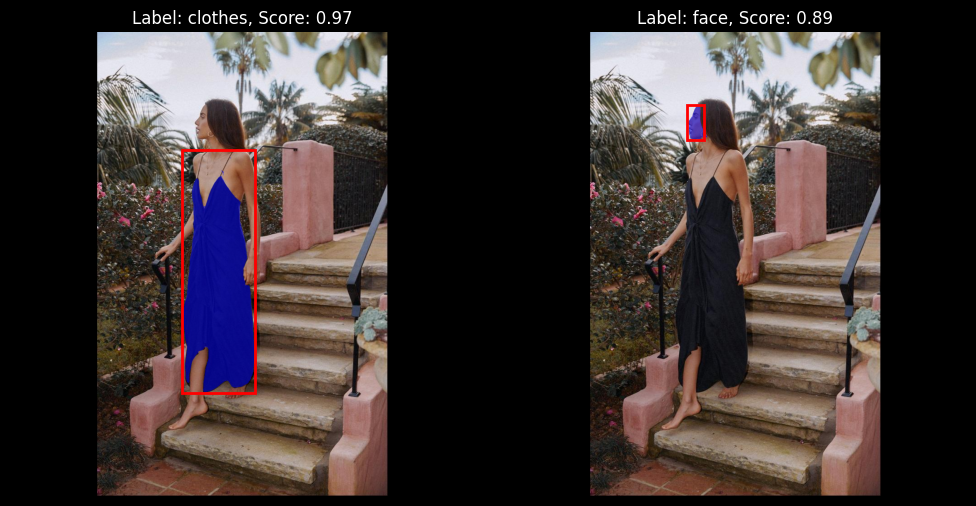

In [9]:
seg.display()

In [10]:
seg.remove_empty_rows()